<a href="https://colab.research.google.com/github/sarisht/AnimaguSwap/blob/main/InclusionList.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random as rm
import copy
import scipy.optimize as opt
import matplotlib.pyplot as plt

image_dir = 'Figures/'

Variables

In [2]:
n = 5  # Number of parties
Ug = np.array([15, 14, 13, 11, 6, 5, 4, 3, 2, 1]) # Utilities of each transaction
m = Ug.size  # Number of transactions
k = 3  # Input list size
biasmax = 6.0  # Maximum bias
u_agg = 20 # Aggregated utility
p = 0.95 # Probability of broadcast


Correlated equilibria

In [3]:

def two_step_transaction_inclusion(n, m, k, Ua, alpha = 1):
    # Step 1: Choose Objects
    Us = copy.deepcopy(Ua)
    N = np.zeros(m, dtype = float)  # Count array, initialized to 0 for each transaction
    N_t = np.zeros(m) # Count array
    S = []

    for _ in range(n * k):
        U_curr = Us / (N + 1)  # Compute current utility
        s = np.argmax(U_curr)  # Find the index of the maximum value
        S.append(s)

        if Us[s] == -1:  # Break if utility of all objects is -1
            break

        N[s] += alpha
        N_t[s] += 1

        if N_t[s] >= n:
            Us[s] = -1  # Set utility of object to -1 if it has been allocated n times

    # Step 2: Allocate Objects
    U = copy.deepcopy(Ua)  # Reset utilities
    P = list(range(1, n + 1))  # Array of party identifiers
    La = {i: set() for i in P}  # Inclusion sets for each party

    U_f = np.divide(U, (N+1-alpha), out=np.zeros_like(U, dtype=float), where=N != 0)  # Compute utility for each selected object

    # Allocate whatever is forced to allocate
    A = sorted(S, key=lambda s: (-U_f[s], s))  # Sort indices in descending order of utility
    for j, obj in enumerate(A):
        La[(j % n) + 1].add(obj)  # Assign objects in round-robin fashion

    return La, N_t

input_lists, num_reps = two_step_transaction_inclusion(n, m, k, Ug)


for party, input_list in input_lists.items():
    print(f"Party {party}: {sorted(input_list)}")



Party 1: [np.int64(1), np.int64(4), np.int64(6)]
Party 2: [np.int64(0), np.int64(1), np.int64(3)]
Party 3: [np.int64(0), np.int64(2), np.int64(3)]
Party 4: [np.int64(0), np.int64(2), np.int64(5)]
Party 5: [np.int64(0), np.int64(1), np.int64(2)]


Calculate bribe required to remove transaction.

In [4]:
def bribe_removetx_unconditional(bribe,txid, input_lists, Ug, N_t, n, m, k, alpha = 1):
    ''' Bribe is paid if tx is removed by party, does not care about overall
    censorship'''

    ''' On receiving a bribe request, update belief that the transaction is
    included in n_t lists. Instead assume that all n_t follow the same logic.'''

    ''' Let p be the probability that you include the tx in the IL'''

    ''' p = (Ug[txid]-bribe)/((N_t[txid]-1)*alpha*bribe)'''

    ''' This would be true, but is not, since a replacement can be used and that
    gives added incentives. TO HANDLE REPLACEMENTS, get the next n_t[txid]
    transactions that would be chosen and do a mixed equilibrium on that -
    and this would be ideal, but im going to assume it to be smaller than Ut/Nt,
    and thus not calculate the replacement cost completely.'''

    if (N_t[txid] == 0): return 0, 1, 0

    S = sum((list(s) for s in input_lists.values()), [])
    Usa = copy.deepcopy(Ug)
    incList = np.unique(S)
    for i in incList:
        if N_t[i] >= n:
          Usa[i] = -1

    repl = np.max(np.divide(Ug, (N_t+1), out=np.zeros_like(Ug, dtype=float), where=N_t != 0))

    effbribe = bribe + repl
    if (N_t[txid] == 1):
        p = int(Ug[txid] > effbribe)

    else: p = max(min((Ug[txid]-effbribe)/((N_t[txid]-1)*alpha*effbribe),1),0)


    return p, (1-p)**N_t[txid], (1-p)*N_t[txid]*bribe

In [5]:
def solve_for_p(n, repl, br, u):
  if repl >= u:
    return 0
  p = 0
  diff = (1 - p)**(n - 1) * br + repl - u/((n - 1)*p + 1)
  while diff < 0:
    p+=0.001
    diff = (1 - p)**(n - 1) * br + repl - u/((n - 1)*p + 1)
    if p>=1:
      break
  return p

In [6]:
def bribe_removetx_conditional(bribe,txid, input_lists, Ug, N_t, n, m, k, alpha = 1):
    ''' Bribe is paid if tx is censored'''

    ''' On receiving a bribe request, update belief that the transaction is
    included in n_t lists. Instead assume that all n_t follow the same logic.'''

    ''' Let p be the probability that you include the tx in the IL'''

    ''' p = (Ug[txid]-bribe)/((N_t[txid]-1)*alpha*bribe)'''

    ''' This would be true, but is not, since a replacement can be used and that
    gives added incentives. TO HANDLE REPLACEMENTS, get the next n_t[txid]
    transactions that would be chosen and do a mixed equilibrium on that -
    and this would be ideal, but im going to assume it to be smaller than Ut/Nt,
    and thus not calculate the replacement cost completely.'''

    S = sum((list(s) for s in input_lists.values()), [])
    Usa = copy.deepcopy(Ug)
    incList = np.unique(S)
    for i in incList:
        if N_t[i] >= n:
          Usa[i] = -1

    repl = np.max(np.divide(Ug, (N_t+1), out=np.zeros_like(Ug, dtype=float), where=N_t != 0))

    if (N_t[txid] == 0): return 0, 1, 0
    p=solve_for_p(N_t[txid], repl, bribe, Ug[txid])

    p = max(min(p,1),0)

    return p, (1-p)**N_t[txid], (1-p)*N_t[txid]*bribe

S = sum((list(s) for s in input_lists.values()), [])
Usa = copy.deepcopy(Ug)
incList = np.unique(S)
for i in incList:
    if num_reps[i] >= n:
      Usa[i] = -1

repl = np.max(np.divide(Ug, (num_reps+1), out=np.zeros_like(Ug, dtype=float), where=num_reps != 0))
bribes = np.clip(Ug-repl, 0, 1000000000)
for bribe in np.arange(0,max(Ug),0.1):
  for txid in range(m):
    # p, op, total_bribe = bribe_removetx_conditional(bribe,txid, input_lists, Ug, num_reps, n, m, k)
    # p_u, op_u, total_bribe_u = bribe_removetx_unconditional(bribe,txid, input_lists, Ug, num_reps, n, m, k)
    print('c',txid, bribe, bribe_removetx_conditional(bribe,txid, input_lists, Ug, num_reps, n, m, k))
    print('u',txid, bribe, bribe_removetx_unconditional(bribe,txid, input_lists, Ug, num_reps, n, m, k))
print(bribes)

c 0 0.0 (1, np.float64(0.0), np.float64(0.0))
u 0 0.0 (1, np.float64(0.0), np.float64(0.0))
c 1 0.0 (1, np.float64(0.0), np.float64(0.0))
u 1 0.0 (1, np.float64(0.0), np.float64(0.0))
c 2 0.0 (1, np.float64(0.0), np.float64(0.0))
u 2 0.0 (1, np.float64(0.0), np.float64(0.0))
c 3 0.0 (1, np.float64(0.0), np.float64(0.0))
u 3 0.0 (1, np.float64(0.0), np.float64(0.0))
c 4 0.0 (1, np.float64(0.0), np.float64(0.0))
u 4 0.0 (1, np.float64(0.0), np.float64(0.0))
c 5 0.0 (1, np.float64(0.0), np.float64(0.0))
u 5 0.0 (1, np.float64(0.0), np.float64(0.0))
c 6 0.0 (1, np.float64(0.0), np.float64(0.0))
u 6 0.0 (1, np.float64(0.0), np.float64(0.0))
c 7 0.0 (0, 1, 0)
u 7 0.0 (0, 1, 0)
c 8 0.0 (0, 1, 0)
u 8 0.0 (0, 1, 0)
c 9 0.0 (0, 1, 0)
u 9 0.0 (0, 1, 0)
c 0 0.1 (1, np.float64(0.0), np.float64(0.0))
u 0 0.1 (np.float64(0.9941002949852508), np.float64(1.2114937830703505e-09), np.float64(0.002359882005899694))
c 1 0.1 (1, np.float64(0.0), np.float64(0.0))
u 1 0.1 (1, np.float64(0.0), np.float64(0.0))

u 2 0.7000000000000001 (np.float64(0.9885496183206107), np.float64(1.5012737473705325e-06), np.float64(0.024045801526717484))
c 3 0.7000000000000001 (1, np.float64(0.0), np.float64(0.0))
u 3 0.7000000000000001 (1, np.float64(0.0), np.float64(0.0))
c 4 0.7000000000000001 (1, np.float64(0.0), np.float64(0.0))
u 4 0.7000000000000001 (1, np.float64(0.0), np.float64(0.0))
c 5 0.7000000000000001 (1, np.float64(0.0), np.float64(0.0))
u 5 0.7000000000000001 (1, np.float64(0.0), np.float64(0.0))
c 6 0.7000000000000001 (0, np.float64(1.0), np.float64(0.7000000000000001))
u 6 0.7000000000000001 (0, np.float64(1.0), np.float64(0.7000000000000001))
c 7 0.7000000000000001 (0, 1, 0)
u 7 0.7000000000000001 (0, 1, 0)
c 8 0.7000000000000001 (0, 1, 0)
u 8 0.7000000000000001 (0, 1, 0)
c 9 0.7000000000000001 (0, 1, 0)
u 9 0.7000000000000001 (0, 1, 0)
c 0 0.8 (1, np.float64(0.0), np.float64(0.0))
u 0 0.8 (np.float64(0.7860696517412935), np.float64(0.002094544504649962), np.float64(0.6845771144278608))
c 1 0

In [7]:
def calculate_bribes(n, m, k, Ua, La, N_t, alpha = 1):
    S = sum((list(s) for s in La.values()), [])
    Usa = copy.deepcopy(Ua)
    incList = np.unique(S)
    for i in incList:
        if N_t[i] >= n:
          Usa[i] = -1

    bribes = np.zeros_like(Ua,dtype=float)

    for i in sorted(incList):
        Us = copy.deepcopy(Usa)
        L = copy.deepcopy(La)
        N2_t = copy.deepcopy(N_t)
        N2 = copy.deepcopy(N_t)*alpha
        bribe = Ua[i]*N2_t[i]
        Us[i] = -1
        newadditions = []
        for j in range(n):
            if i in L[j+1]:
                L[j+1].remove(i)
                U_curr = Us / (N2 + 1)
                s = np.argmax(U_curr)  # Find the index of the maximum value



                if Us[s] == -1:  # Break if utility of all objects is -1
                    break

                L[j+1].add(s)
                newadditions.append(s)

                N2[s] += alpha
                N2_t[s] += 1

                if N2_t[s] >= n:
                    Us[s] = -1  # Set utility of object to -1 if it has been allocated n times

        U_f = np.divide(Ua, (N2+1-alpha), out=np.zeros_like(Ua, dtype=float), where=N2 != 0)
        for h in newadditions:
            bribe-= U_f[h]
        bribes[i] = max(0.,bribe)

    return bribes

bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)
print(bribes)

[46.58333333 32.08333333 28.83333333 15.25        2.33333333  1.33333333
  0.33333333  0.          0.          0.        ]


In [8]:
n = 5  # Number of parties
Ug = np.array([10]*15, dtype = float) # Utilities of each transaction

example_allocations = [{1:{0,5,10},2:{1,6,11},3:{2,7,12},4:{3,8,13},5:{4,9,14}},
                       {1:{0,1,2},2:{0,1,2},3:{0,1,2},4:{0,1,2},5:{0,1,2}},
                       {1:{1,4,6},2:{0,1,3},3:{0,2,3},4:{0,2,5},5:{0,1,2}},
                       {1:{0,2,4},2:{0,1,2},3:{1,3,5},4:{0,1,3},5:{0,2,3}},
                       {1:{0,1,2},2:{0,1,2},3:{2,3,4},4:{0,1,3},5:{0,1,3}}]
m = Ug.size  # Number of transactions
k = 3  # Input list size
biasmax = 6.0  # Maximum bias
u_agg = 20
p = 0.5
for input_lists in example_allocations:
    lst = sum((list(s) for s in input_lists.values()), [])
    num_reps = np.array([lst.count(i) for i in range(m)])
    # print(input_lists,num_reps)
    bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)
    print(bribes)

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Calculate utility of some random allocation

In [9]:
def calculate_utility(input_lists, Ug, N_t, alpha=1):
    U_f = np.divide(Ug, ((N_t-1)*alpha+1), out=np.zeros_like(Ug, dtype=float), where=N_t != 0)
    utilities = [0,0,0,0,0]
    i=0
    for party,input_list in input_lists.items():
        for input in sorted(input_list):
            utilities[i] += U_f[input]
        i+=1
    return utilities

utilities = calculate_utility(input_lists, Ug, num_reps)

This part decides whether or not ILProposer would broadcast

In [10]:
utilities

[np.float64(8.333333333333334),
 np.float64(8.333333333333334),
 np.float64(16.666666666666668),
 np.float64(8.333333333333334),
 np.float64(8.333333333333334)]

In [11]:
import numba
from numba import jit, prange
import numpy as np
import random as rm
import copy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [12]:
n = 36  # Number of parties
m = 200  # Number of transactions
k = 6  # Input list size
Ug = np.random.beta(1, 4, size=m) * 30
bias_max = 6.0  # Maximum bias
bias_min = 0
lc  = 6000
u_agg = 80 # Aggregated utility

In [13]:
def get_percentile_index(lst, percentile):
    # Sort the list
    sorted_lst = sorted(lst)
    # Compute the index in the sorted list:
    # Multiply (n-1) by the percentile and round to get the nearest index.
    idx = int(round(percentile * (len(lst) - 1)))
    # Get the value at that percentile in the sorted list
    percentile_value = sorted_lst[idx]
    # Return the index of that value in the original list (first occurrence)
    return list(lst).index(percentile_value)

In [14]:
input_lists, num_reps = two_step_transaction_inclusion(n, m, k, Ug, (n-2)/n)

for bribe in np.arange(0,max(Ug),0.1):
  for txid in [np.argmax(num_reps), get_percentile_index(num_reps, 0.75),get_percentile_index(num_reps, 0.50)]:
    # p, op, total_bribe = bribe_removetx_conditional(bribe,txid, input_lists, Ug, num_reps, n, m, k)
    # p_u, op_u, total_bribe_u = bribe_removetx_unconditional(bribe,txid, input_lists, Ug, num_reps, n, m, k)

    print('c',txid, bribe, bribe_removetx_conditional(bribe,txid, input_lists, Ug, num_reps, n, m, k))
    print('u',txid, bribe, bribe_removetx_unconditional(bribe,txid, input_lists, Ug, num_reps, n, m, k))
bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)[[np.argmax(num_reps), get_percentile_index(num_reps, 0.95),get_percentile_index(num_reps, 0.8)]]
bribes

c 4 0.0 (0.9960000000000008, np.float64(1.0239999999990097e-12), np.float64(0.0))
u 4 0.0 (np.float64(0.9958000738486765), np.float64(1.306797426724737e-12), np.float64(0.0))
c 0 0.0 (1, np.float64(0.0), np.float64(0.0))
u 0 0.0 (1, np.float64(0.0), np.float64(0.0))
c 18 0.0 (1, np.float64(0.0), np.float64(0.0))
u 18 0.0 (1, np.float64(0.0), np.float64(0.0))
c 4 0.1 (0.9960000000000008, np.float64(1.0239999999990097e-12), np.float64(0.001999999999999613))
u 4 0.1 (np.float64(0.9633462602115395), np.float64(6.615938537770137e-08), np.float64(0.01832686989423027))
c 0 0.1 (1, np.float64(0.0), np.float64(0.0))
u 0 0.1 (1, np.float64(0.0), np.float64(0.0))
c 18 0.1 (1, np.float64(0.0), np.float64(0.0))
u 18 0.1 (1, np.float64(0.0), np.float64(0.0))
c 4 0.2 (0.9960000000000008, np.float64(1.0239999999990097e-12), np.float64(0.003999999999999226))
u 4 0.2 (np.float64(0.9325403977833219), np.float64(1.3970722937661063e-06), np.float64(0.06745960221667813))
c 0 0.2 (1, np.float64(0.0), np.floa

array([74.31292886, 53.57167173, 10.62043817])

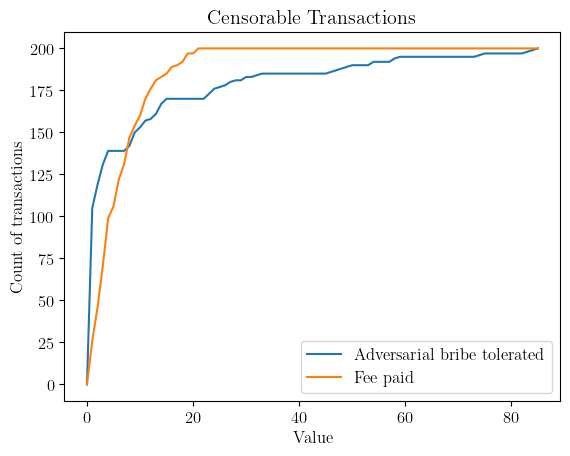

In [15]:
bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)
fees = Ug

# Determine the common range covering both bribes and fees
common_min = min(bribes.min(), fees.min())
common_max = max(bribes.max(), fees.max())

# Create a common x_range for both datasets
x_range = np.arange(common_min, common_max + 1)

# Compute cumulative counts using the same x_range for both arrays
sorted_bribes = np.sort(bribes)
sorted_fees = np.sort(fees)

cumulative_bribes = np.searchsorted(sorted_bribes, x_range, side='left')
cumulative_fees = np.searchsorted(sorted_fees, x_range, side='left')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif",
})

plt.rcParams.update({'font.size': 12})

# Plot both cumulative line plots on the same axes
plt.plot(x_range, cumulative_bribes, linestyle='-', label='Adversarial bribe tolerated')
plt.plot(x_range, cumulative_fees, linestyle='-', label='Fee paid')

plt.xlabel('Value')
plt.ylabel('Count of transactions')
plt.title('Censorable Transactions')
plt.legend()
plt.show()



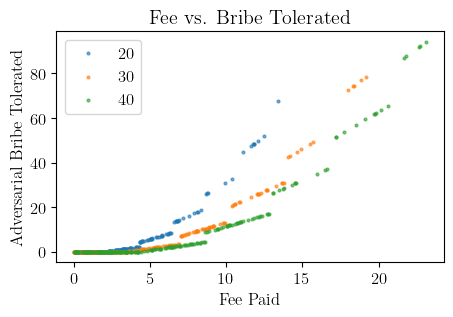

In [16]:
plt.figure(figsize=(5, 3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif",
})

plt.rcParams.update({'font.size': 12})
for i in range(3):
  Ug = np.random.beta(1, 5, size=m) * (20+10*i)
  input_lists,num_reps = two_step_transaction_inclusion(n, m, k, Ug)
  bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)
  fees = Ug
  plt.scatter(fees, bribes, s=4, alpha=0.6, label = str(20+10*i))  # alpha for slight transparency if points overlap

plt.xlabel('Fee Paid')
plt.ylabel('Adversarial Bribe Tolerated')
plt.title('Fee vs. Bribe Tolerated')
plt.legend()
plt.show()


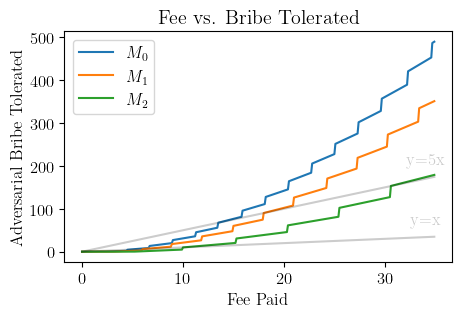

In [17]:
plt.figure(figsize=(5, 3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif",
})

plt.rcParams.update({'font.size': 12})
n= 36
for i in range(3):
  Ug = np.random.beta(1, 5, size=m) * (20+10*i)
  x_axis = np.arange(0,35,0.1)
  y_axis = []
  for g in x_axis:
    Ug[0] = g
    input_lists,num_reps = two_step_transaction_inclusion(n, m, k, Ug)
    bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)
    y_axis.append(bribes[0])
  plt.plot(x_axis, y_axis, linestyle='-', label= '$M_'+str(i)+'$')

plt.plot(x_axis,x_axis,color='black',alpha=0.2,label='_x')
plt.plot(x_axis,5*x_axis,color='black',alpha=0.2,label='_4x')

plt.text(34, 55, 'y=x', ha='center', va='bottom', alpha = 0.2)
plt.text(34, 195, 'y=5x', ha='center', va='bottom', alpha = 0.2)

plt.xlabel('Fee Paid')
plt.ylabel('Adversarial Bribe Tolerated')
plt.title('Fee vs. Bribe Tolerated')
plt.legend()
plt.savefig(image_dir+'FeeBribeMempool.pdf', format='pdf',bbox_inches='tight')
plt.show()


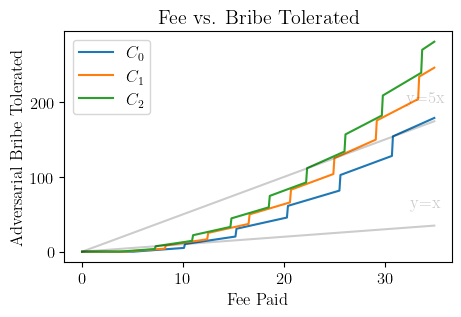

In [18]:
plt.figure(figsize=(5, 3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif",
})


Ug = np.random.beta(1, 5, size=m) * 30
plt.rcParams.update({'font.size': 12})
i = 0
ks = 5
for n in [24,32,40]:
  k = ks
  x_axis = np.arange(0,35,0.1)
  y_axis = []
  for g in x_axis:
    Ug[0] = g
    input_lists,num_reps = two_step_transaction_inclusion(n, m, k, Ug)
    bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)
    y_axis.append(bribes[0])
  plt.plot(x_axis, y_axis, linestyle='-', label= '$C_'+str(i)+'$')
  i+=1

plt.plot(x_axis,x_axis,color='black',alpha=0.2,label='_x')
plt.plot(x_axis,5*x_axis,color='black',alpha=0.2,label='_5x')

plt.text(34, 55, 'y=x', ha='center', va='bottom', alpha = 0.2)
plt.text(34, 195, 'y=5x', ha='center', va='bottom', alpha = 0.2)

plt.xlabel('Fee Paid')
plt.ylabel('Adversarial Bribe Tolerated')
plt.title('Fee vs. Bribe Tolerated')
plt.legend()
plt.savefig(image_dir+'FeeBribeCommittee.pdf', format='pdf',bbox_inches='tight')
plt.show()

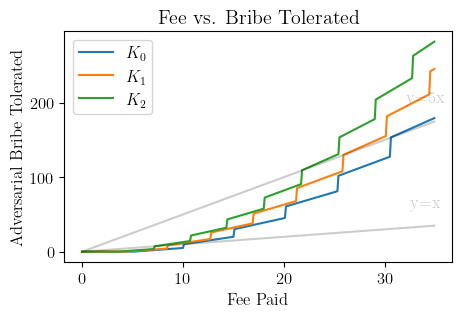

In [19]:
plt.figure(figsize=(5, 3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif",
})


Ug = np.random.beta(1, 5, size=m) * 30
plt.rcParams.update({'font.size': 12})
i = 0
n = 36
for k in [3,4,5]:
  x_axis = np.arange(0,35,0.1)
  y_axis = []
  for g in x_axis:
    Ug[0] = g
    input_lists,num_reps = two_step_transaction_inclusion(n, m, k, Ug)
    bribes = calculate_bribes(n,m,k,Ug,input_lists,num_reps)
    y_axis.append(bribes[0])
  plt.plot(x_axis, y_axis, linestyle='-', label= '$K_'+str(i)+'$')
  i+=1

plt.plot(x_axis,x_axis,color='black',alpha=0.2,label='_x')
plt.plot(x_axis,5*x_axis,color='black',alpha=0.2,label='_5x')

plt.text(34, 55, 'y=x', ha='center', va='bottom', alpha = 0.2)
plt.text(34, 195, 'y=5x', ha='center', va='bottom', alpha = 0.2)

plt.xlabel('Fee Paid')
plt.ylabel('Adversarial Bribe Tolerated')
plt.title('Fee vs. Bribe Tolerated')
plt.legend()
plt.savefig(image_dir+'FeeBribeILSize.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [20]:
# Initialize p_bias with a uniform randomization
bias_values = np.linspace(bias_min, bias_max, lc)
p_values = np.ones_like(bias_values) * 0.6  # Initial guess


@jit(nopython=True)
def P_max(eta, p_values):

    if eta < bias_min:
        return 0

    idx = np.searchsorted(bias_values, eta, side="right") - 1
    idx2 = np.searchsorted(bias_values, eta-1, side="right") - 1

    if idx2 <= 0:
        return 0
    if idx >= len(p_values):
        return 1

    sum_action_0 = np.sum(1 - p_values[:idx])
    sum_action_1 = np.sum(p_values[:idx2])

    prob_less_than_eta = (sum_action_0 + sum_action_1) / lc if lc > 0 else 0
    prob_max = min(prob_less_than_eta, 1) ** (n - 1)

    return prob_max


@jit(nopython=True)
def compute_direction(bias, p_values, v, a, iter):
  payoff_0 = v + a * P_max(bias, p_values)
  payoff_1 = (v + a) * P_max(bias + 1, p_values)
  idx = np.searchsorted(bias_values, bias, side="right") - 1
  delta = 1e-4 + 1e-2*p_values[idx]
  gradient_payoff = ((p_values[idx]+delta)*payoff_1 + (1 - p_values[idx]-delta) * payoff_0) - ((p_values[idx]-delta)*payoff_1 + (1 - p_values[idx]+delta) * payoff_0)
  return gradient_payoff

@jit(nopython=True)
def compute_err(bias, p_values, v, a):
  payoff_0 = v + a * P_max(bias, p_values)
  payoff_1 = (v + a) * P_max(bias + 1, p_values)
  idx = np.searchsorted(bias_values, bias, side="right") - 1
  expected_payoff = p_values[idx] * payoff_1 + (1 - p_values[idx]) * payoff_0
  return abs(max(payoff_1,payoff_0) - expected_payoff)


@jit(nopython=True, parallel=True)
def compute_direction_parallel(bias_values, p_values, v, a,iter):
    """Compute direction vector in parallel."""
    direction = np.empty_like(p_values)
    for i in prange(len(bias_values)):
        direction[i] = compute_direction(bias_values[i], p_values, v, a, iter)  # User-defined function
    return direction


@jit(nopython=True, parallel=True)
def compute_error(bias_values, p_values, v, a):
    """Compute direction vector in parallel."""
    error = np.empty_like(p_values)
    for i in prange(len(bias_values)):
        error[i] = compute_err(bias_values[i], p_values, v, a)  # User-defined function
    return np.max(error)


def iterative_update_parallel(v,a, bias):
    global p_values
    max_iterations = 100000
    tolerance = 1e-4
    step_size = 1

    for iteration in range(max_iterations):
        # Compute direction in parallel
        direction = compute_direction_parallel(bias_values, p_values, v, a, iteration)

        # Update p_values and clip in-place
        p_values += step_size * direction
        np.clip(p_values, 0, 1, out=p_values)

        p_values.sort()

        if iteration % 100 == 0:
            diff = compute_error(bias_values, p_values, v, a)/(v+a)
            # print(f"Iteration {iteration}, max difference: {diff}")

            if diff < tolerance:
                # print(f"Converged after {iteration} iterations.")
                idx = np.searchsorted(bias_values, bias, side="right") - 1
                p_broadcast = p_values[idx]
                return p_broadcast, p_values

    print("Maximum iterations reached.")
    idx = np.searchsorted(bias_values, bias, side="right") - 1
    p_broadcast = p_values[idx]
    return p_broadcast, p_values


This part finds the aggregate as governed by aucil

In [21]:
# Step 0: Generate auction bias
biases = np.random.rand(n)*bias_max # Generate bias for each party

In [22]:
k = 5
n = 36
m = 200
Ug = np.random.beta(1, 5, size=m) * 30
input_lists, num_reps = two_step_transaction_inclusion(n, m, k, Ug)
v = sum([Ug[i]/num_reps[i] for i in input_lists[1]])
p_vals = []
bias_values = np.linspace(bias_min, bias_max, lc)
p_values = np.ones_like(bias_values) * 0.6  # Initial guess
for a in [32,128,256]:
    u_agg = a
    p_broadcast, p_val = iterative_update_parallel(v, a, biases[1])
    bias_values = np.linspace(bias_min, bias_max, lc)
    p_values = np.ones_like(bias_values) * 0.6  # Initial guess
    p_vals.append(p_val)

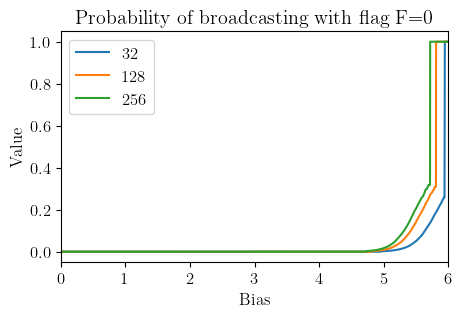

In [23]:
plt.figure(figsize=(5, 3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif",
})

plt.rcParams.update({'font.size': 12})
i = 0
ap = [32,128,256]
for p_val in p_vals:
    plt.plot(bias_values, p_val, label= str(ap[i]))
    i+=1
plt.xlabel('Bias')
plt.ylabel('Value')
plt.title('Probability of broadcasting with flag F=0')
plt.margins(x=0)
plt.legend()
plt.savefig(image_dir+'BroadcastEquilibrium.pdf', format='pdf',bbox_inches='tight')
plt.show()


In [24]:
max(Ug)

np.float64(19.536095920948146)

In [25]:
def aucil_log_position(bias_max, n, m, k, Ug, party_id):

    bias = biases[party_id-1]

    # Step 1: Generate input lists

    # Generate input lists with initial thought that two parties will not broadcast (in expectation)
    input_lists, num_reps = two_step_transaction_inclusion(n, m, k, Ug, (n-2)/n)

    # Step 2: Decide whether or not to broadcast

    bias_values = np.linspace(bias_min, bias_max, lc)
    p_values = np.ones_like(bias_values) * 0.6  # Initial guess

    v = sum([Ug[i]/num_reps[i] for i in input_lists[party_id]])
    a = u_agg
    p_broadcast = 0
    p_vals = np.zeros_like(bias_values)

    if bias > bias_max-1.5:
        p_broadcast,p_vals = iterative_update_parallel(v,a,bias)

    print(party_id, bias, v, a, p_broadcast)

    if np.random.rand() > p_broadcast:
        flag = 1
    else:
        print(f"No Flag Broadcast by {party_id}")
        flag = 0

    return party_id, input_lists[party_id], flag, p_vals

broadcasts = []

for i in range(1,n+1):
    broadcasts.append(aucil_log_position(bias_max, n, m, k, Ug, i))



1 2.2618782437416742 27.09525489455149 256 0
2 2.4372466373587294 26.716538014187506 256 0
3 5.999504980863144 26.66252043579519 256 1.0
No Flag Broadcast by 3
4 1.6291625647356327 26.66697406657453 256 0
5 1.7583765252484642 26.432382105035977 256 0
6 3.2778560265370036 26.142481031551654 256 0
7 0.2530732665034203 25.81140238637758 256 0
8 0.9395094690697348 25.914861732630516 256 0
9 0.3636006829271947 25.61722603214389 256 0
10 2.3554231866612367 25.53874489419362 256 0
11 0.8413873895551716 25.435458751655226 256 0
12 2.29587954029334 25.27348849966294 256 0
13 1.4813609039219304 25.2050652570989 256 0
14 2.4229145276697164 25.079372598812697 256 0


15 5.482131202032199 24.78612930913021 256 0.2044224107649505
16 4.6015222866358325 24.73753024429844 256 0.0
17 1.3704759313595702 24.835842113333893 256 0
18 5.078159987998077 25.004748619826753 256 0.030114168278727482
19 1.744083525176164 24.680255282108757 256 0
20 3.178280724275588 24.490205176101078 256 0
21 1.6053364497610498 24.452837892726585 256 0
22 2.0329004478332307 24.495658100803528 256 0
23 0.18757666775253257 24.426188664445508 256 0
24 0.26160031206715995 24.256680170088256 256 0
25 4.14327046511383 24.08596031988736 256 0
26 2.7538295604065395 24.292563921062232 256 0
27 1.3009429282916554 23.79493131609979 256 0
28 0.21791233571813362 23.61564470168073 256 0
29 3.840188500044233 23.482010647724906 256 0
30 0.8090583170477996 23.464259027150952 256 0
31 4.330456881206482 23.57520024253173 256 0
32 1.259229819260175 23.39563137734823 256 0
33 5.381586071684813 23.513499702963543 256 0.1482513851701025
34 2.4273096001979546 23.520847057104795 256 0
35 0.96909371870325

In [26]:
def bidgenerator(broadcasts, party_id):
    bid = 0
    inclusion_list = set()
    for (pid, input_list, flag, p_vals) in broadcasts:
        if flag or party_id == pid:
            bid+=1
            inclusion_list.update(input_list)
    return bid+biases[party_id-1], inclusion_list

highest_bid = 0
highest_bidder = 0
for i in range(1,n+1):
    sth = bidgenerator(broadcasts, i)
    print(f"Party Id {i} generates a bid {sth[0]}")
    if sth[0] > highest_bid:
        highest_bid = sth[0]
        highest_bidder = i
print(f"The highest bidder is party {highest_bidder} with a bid of {highest_bid}")

Party Id 1 generates a bid 37.26187824374168
Party Id 2 generates a bid 37.437246637358726
Party Id 3 generates a bid 41.99950498086314
Party Id 4 generates a bid 36.62916256473563
Party Id 5 generates a bid 36.758376525248465
Party Id 6 generates a bid 38.277856026537
Party Id 7 generates a bid 35.25307326650342
Party Id 8 generates a bid 35.93950946906973
Party Id 9 generates a bid 35.36360068292719
Party Id 10 generates a bid 37.355423186661234
Party Id 11 generates a bid 35.84138738955517
Party Id 12 generates a bid 37.29587954029334
Party Id 13 generates a bid 36.48136090392193
Party Id 14 generates a bid 37.42291452766972
Party Id 15 generates a bid 40.4821312020322
Party Id 16 generates a bid 39.601522286635834
Party Id 17 generates a bid 36.37047593135957
Party Id 18 generates a bid 40.07815998799808
Party Id 19 generates a bid 36.744083525176165
Party Id 20 generates a bid 38.17828072427559
Party Id 21 generates a bid 36.60533644976105
Party Id 22 generates a bid 37.0329004478

This part introduces bribery in the game

In [27]:
def compute_posterior(biases, p_vals):
    
    prior = np.ones_like(biases) / len(biases)
    
    # Compute the unnormalized posterior: P(event | bias) * P(bias)
    unnormalized_posterior = p_vals * prior
    
    # Normalize so that the probabilities sum to 1
    normalization_constant = unnormalized_posterior.sum()
    if normalization_constant == 0:
        raise ValueError("Normalization constant is zero. Check that p_vals and prior are valid.")
    
    posterior = unnormalized_posterior / normalization_constant
    return posterior

In [28]:
def bidgenerator(broadcasts, party_id, subt = []):
    bid = 0
    if len(subt) != 0:
        tx = subt[0]
    inclusion_list = set()
    for (pid, input_list, flag, p_vals) in broadcasts:
        if tx in input_list:
            continue
        if flag or party_id == pid:
            bid+=1
            inclusion_list.update(input_list)
    return bid+biases[party_id-1], inclusion_list

bribe_for_broadcast = 0
bribe_for_nb = 0

for tx in range(m):
    num_rep = num_reps[tx]
    highest_bid = 0
    highest_bidder = 0
    for i in range(1,n+1):
        sth = bidgenerator(broadcasts, i)
        print(f"Party Id {i} generates a bid {sth[0]}")
        if sth[0] > highest_bid:
            highest_bid = sth[0]
            highest_bidder = i
    print(f"The highest bidder is party {highest_bidder} with a bid of {highest_bid}")

UnboundLocalError: cannot access local variable 'tx' where it is not associated with a value